In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install japanize-matplotlib

In [3]:
# 必要なパッケージをインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

In [4]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt

In [5]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.25.2
5.10.4
0.15.1


In [6]:
df = pd.read_csv(f"/content/gdrive/MyDrive/Pythonではじめる会計データサイエンス/data/sec8/data_2_train.csv", index_col=0)
test_df = pd.read_csv(f"/content/gdrive/MyDrive/Pythonではじめる会計データサイエンス/data/sec8/data_2_test.csv", index_col=0)

## データ確認

In [7]:
train_df = df.iloc[:150, :].sort_values(by="BusinessSectorLabel")
valid_df = df.iloc[150:, :].sort_values(by="BusinessSectorLabel")

In [8]:
train_df[(train_df["ReturnOnAsset"] >= 0.7) & (train_df["ReturnOnAsset"] <= 0.9)]

,Default,ReturnOnAsset,BusinessSectorLabel
33,0,0.868886,1
70,0,0.857548,1
13,0,0.876169,1
31,0,0.714790,2
34,0,0.757328,2
144,0,0.780027,3
52,0,0.858286,3
106,0,0.725474,4
53,1,0.758637,4
79,1,0.720686,4


In [9]:
print(train_df.shape)
display(train_df.head())

(150, 3)


,Default,ReturnOnAsset,BusinessSectorLabel
126,1,0.490561,1
43,0,-1.021886,1
128,0,1.202055,1
50,0,0.346058,1
132,0,-0.508457,1


In [10]:
test_df =test_df.sort_values(by="BusinessSectorLabel")
print(test_df.shape)
display(test_df.head())

(30, 3)


,ReturnOnAsset,BusinessSectorLabel,LoanValue
0,-0.348984,1,114151.489100
4,-3.016032,1,166991.222813
7,0.501430,1,135429.780002
2,0.309318,2,87070.151075
23,-0.134249,2,158197.064212


## モデリング

In [11]:
# 配列を作成
y_array = train_df["Default"].values
roa_array = train_df["ReturnOnAsset"].values
sector_array = train_df["BusinessSectorLabel"].values
cl_array = sector_array

print(y_array[:5])
print(roa_array[:5])
print(sector_array[:5])
print(cl_array[:5])
print(pd.Series(cl_array).unique())

[1 0 0 0 0]
[ 0.49056104 -1.02188594  1.20205486  0.34605775 -0.50845713]
[1 1 1 1 1]
[1 1 1 1 1]
[1 2 3 4 5 6]


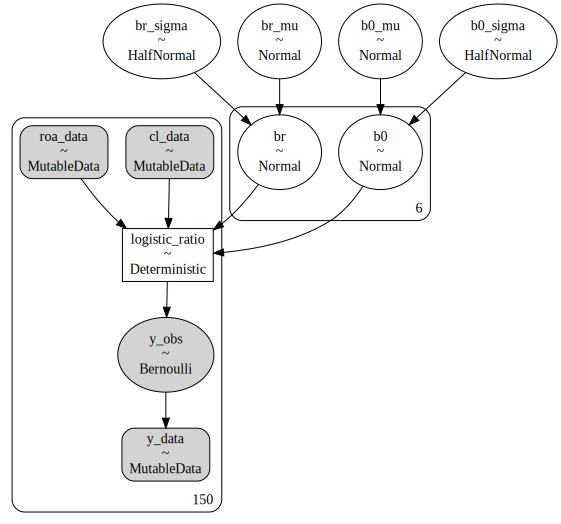

In [12]:
# 確率モデルの定義
model = pm.Model()

with model:
  # 観測値をDataで定義
  y_data = pm.Data("y_data", y_array, mutable=True)
  roa_data = pm.Data("roa_data", roa_array, mutable=True)

  # クラス変数を定義
  cl_data = pm.Data("cl_data", cl_array, mutable=True)

  # ROAの回帰係数（パラメータ）を確率変数として定義（階層ベイズ）
  br_mu = pm.Normal("br_mu", mu=0, sigma=10)
  br_sigma = pm.HalfNormal("br_sigma", sigma=10)
  br = pm.Normal("br", mu=br_mu, sigma=br_sigma, shape=(6, ))


  # 切片の回帰係数（パラメータ）を確率変数として定義（階層ベイズ）
  b0_mu = pm.Normal("b0_mu", mu=0, sigma=10)
  b0_sigma = pm.HalfNormal("b0_sigma", sigma=10)
  b0 = pm.Normal("b0", mu=b0_mu, sigma=b0_sigma, shape=(6, ))

  # 目的変数の期待値を確率変数として定義
  logistic_ratio = pm.Deterministic("logistic_ratio", 1 / (1 + pt.exp(-(br[cl_data - 1] * roa_data + b0[cl_data - 1]))))

  # 観測値を持つ確率変数として定義
  y_obs = pm.Bernoulli("y_obs", p=logistic_ratio, observed=y_data)

g = pm.model_to_graphviz(model)
display(g)

In [13]:
# パラメータのMCMCサンプリング
with model:
    idata1 = pm.sample(
        chains = 2,
        tune = 8000,
        draws = 2000,
        random_seed = 42
    )

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


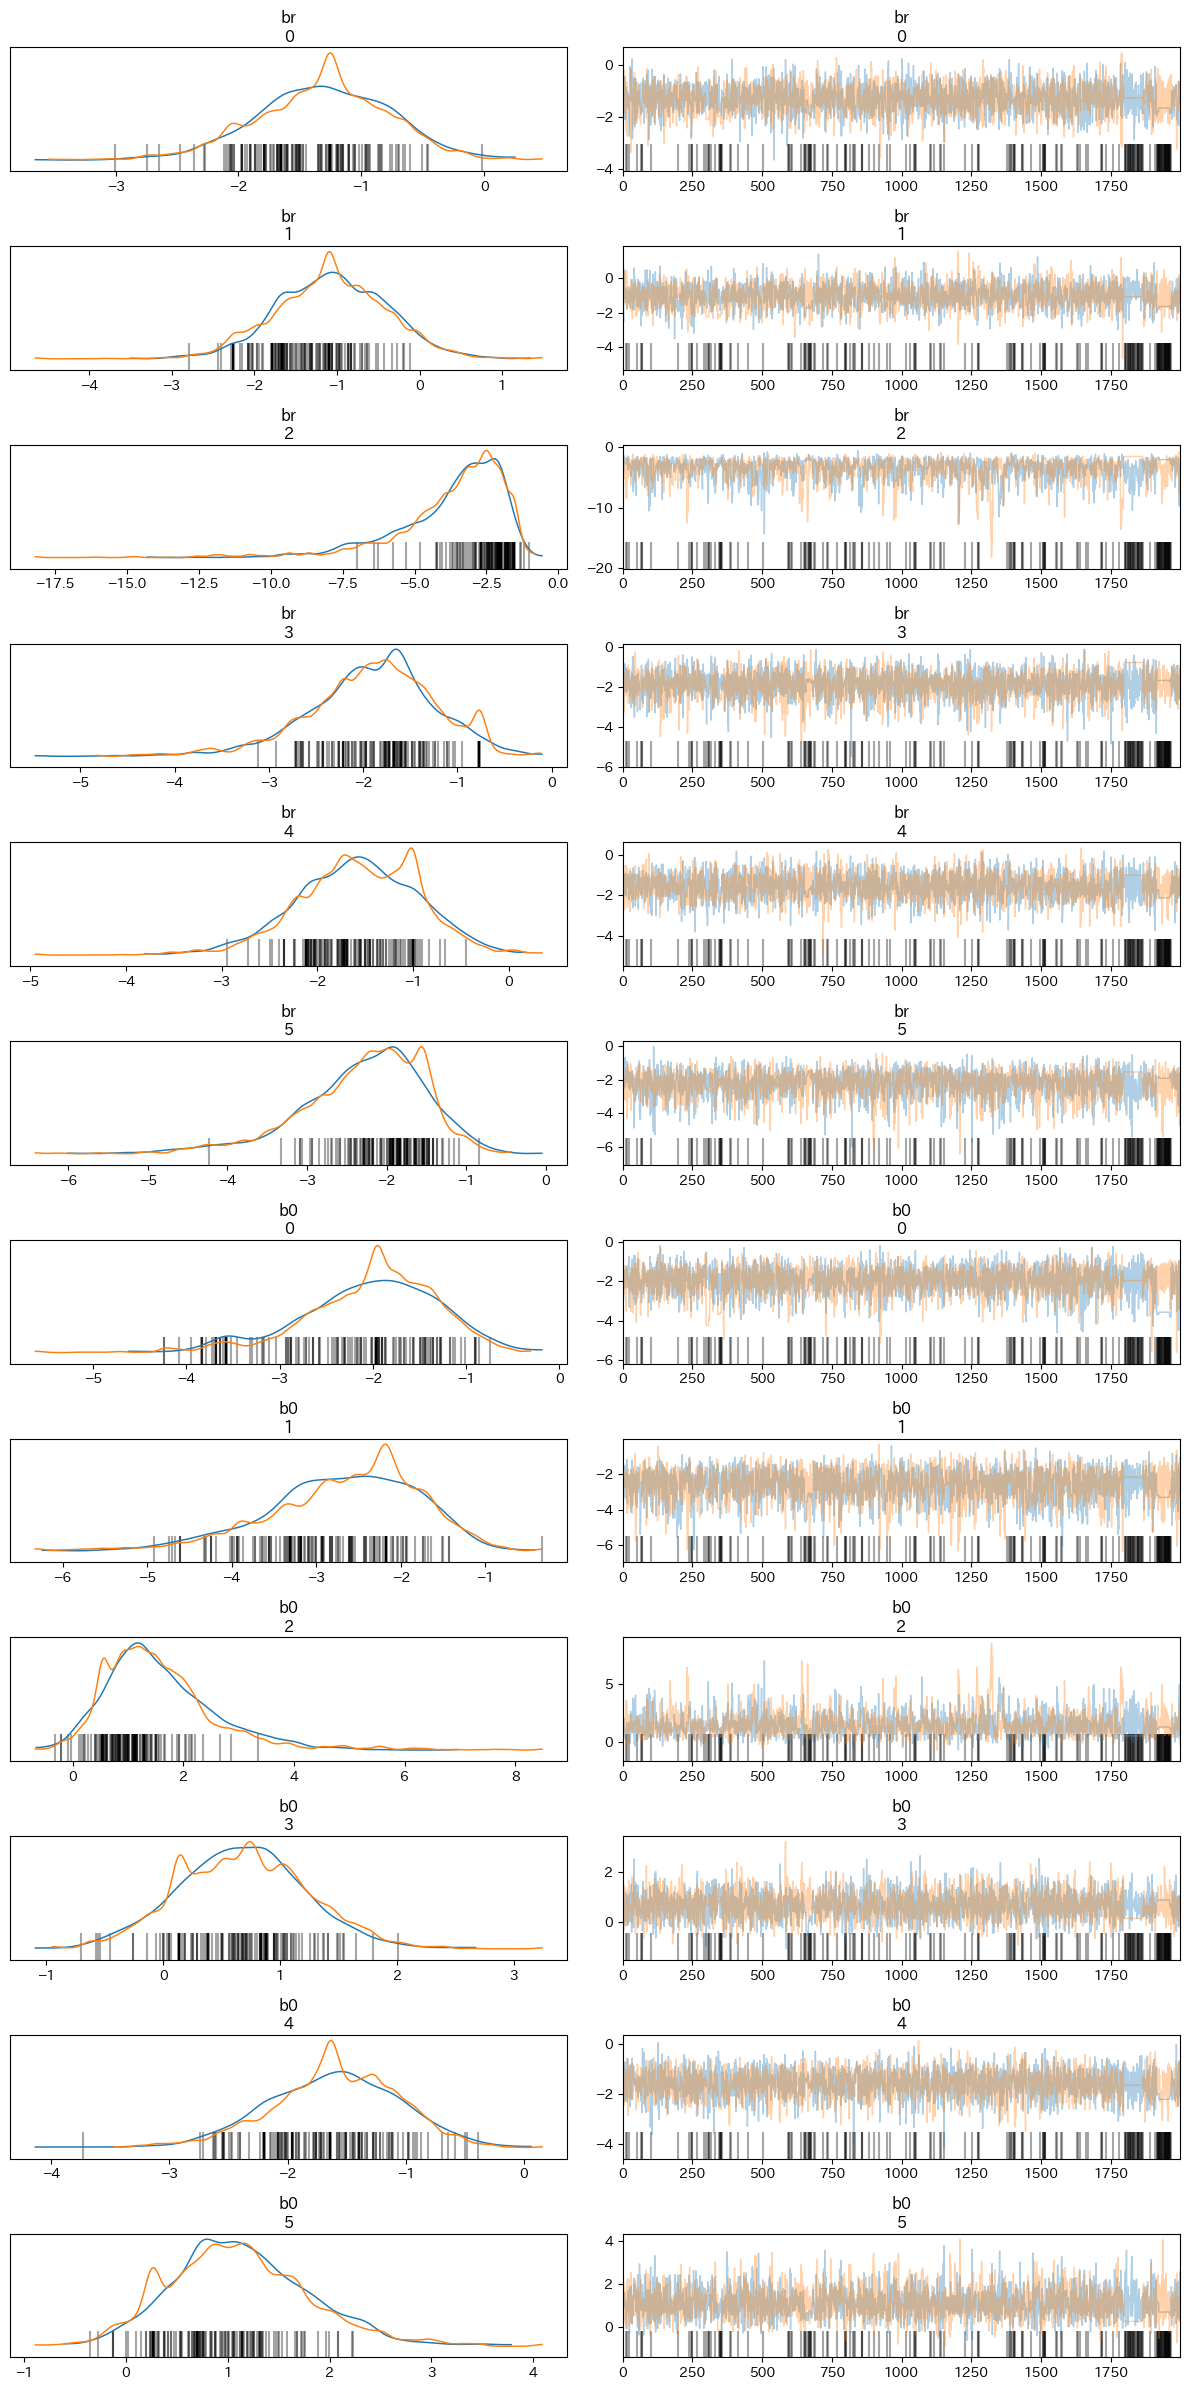

In [14]:
# 事後分布の可視化
az.plot_trace(idata1, compact=False, var_names=["br", "b0"])
plt.tight_layout();

In [15]:
# MCMCサンプルの統計量
az.summary(idata1, var_names=["br", "b0"])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
br[0],-1.313,0.545,-2.347,-0.332,0.010,0.008,2782.0,2384.0,1.00
br[1],-1.069,0.669,-2.343,0.119,0.017,0.012,1605.0,1806.0,1.00
br[2],-3.693,1.888,-7.192,-1.179,0.071,0.050,645.0,178.0,1.00
br[3],-1.902,0.678,-3.137,-0.670,0.021,0.015,959.0,167.0,1.00
br[4],-1.565,0.635,-2.700,-0.337,0.012,0.009,2752.0,2779.0,1.00
br[5],-2.290,0.781,-3.758,-0.890,0.019,0.014,1834.0,2050.0,1.00
b0[0],-2.019,0.719,-3.572,-0.840,0.024,0.021,1275.0,224.0,1.01
b0[1],-2.670,0.898,-4.414,-1.164,0.021,0.016,2057.0,1634.0,1.00
b0[2],1.566,1.024,-0.051,3.501,0.034,0.026,1119.0,1101.0,1.00
b0[3],0.676,0.549,-0.368,1.690,0.013,0.009,1898.0,2475.0,1.00


In [16]:
# 3(=[2])の業態は、ROAが小さいとデフォルトリスクが他より大きいが、ROAのデフォルトリスクへの感度が他の業態より大きい。

## モデルの評価

,Default,ReturnOnAsset,BusinessSectorLabel,pred_prob
188,0,0.606404,1,0.082711
222,0,0.355717,1,0.108568
198,0,0.185156,1,0.128235
230,1,-0.017718,1,0.156623
235,1,0.859871,1,0.063635


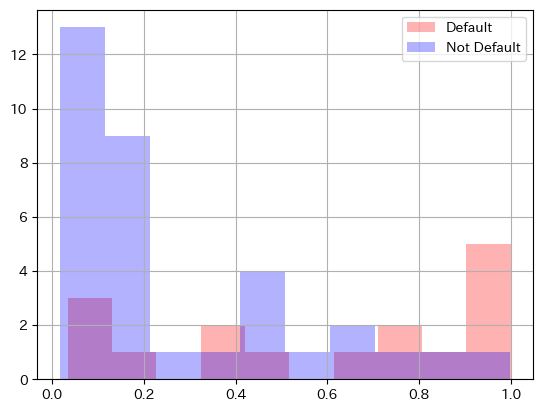

In [17]:
# 確率予測
threshold = 65 # 予測確率の上位65%点を予測に利用
predict_val_df = pd.DataFrame()
for i in range(len(pd.Series(cl_array).unique())):
  # パラメータ抽出
  br_array = idata1.posterior["br"].values[:, :, i].reshape(4000, 1)
  b0_array = idata1.posterior["b0"].values[:, :, i].reshape(4000, 1)

  # 予測するデータを抽出
  valid_df_selected = valid_df[valid_df["BusinessSectorLabel"] == i+1]
  valid_roa = valid_df_selected["ReturnOnAsset"].values.reshape(1, len(valid_df_selected))

  # 貸倒確率予測
  pred_prob_array = 1 / (1 + np.exp(-(br_array @ valid_roa + b0_array)))
  pred_prob = np.percentile(pred_prob_array, threshold, axis=0) # 閾値を元に確率を抽出

  # 予測値をデータフレームに格納
  valid_df_selected = valid_df_selected.copy()
  valid_df_selected["pred_prob"] = pred_prob
  predict_val_df = pd.concat([predict_val_df, valid_df_selected])

display(predict_val_df.head())
predict_val_df[predict_val_df["Default"] == 1]["pred_prob"].hist(color="r", alpha=0.3, label="Default")
predict_val_df[predict_val_df["Default"] == 0]["pred_prob"].hist(color="b", alpha=0.3, label="Not Default")
plt.legend()
plt.show()

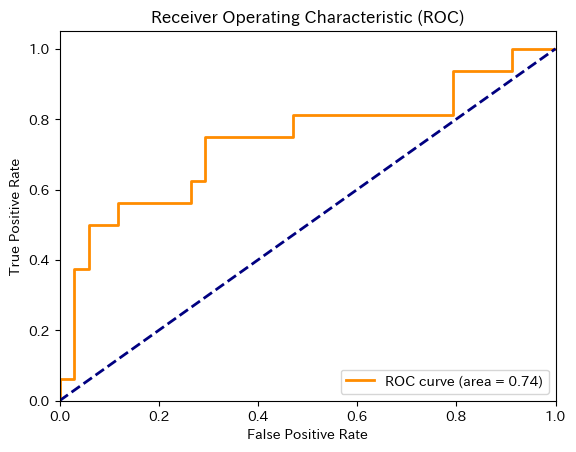

In [18]:
# ROCカーブの描画
from sklearn.metrics import roc_curve, roc_auc_score

# FPR, TPR, 閾値を計算
fpr, tpr, thresholds = roc_curve(predict_val_df['Default'], predict_val_df['pred_prob'])

# AUCを計算
auc = roc_auc_score(predict_val_df['Default'], predict_val_df['pred_prob'])

# ROC曲線をプロット
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## デフォルトスコア（予測分布）の確認

Default
0    3
Name: count, dtype: int64


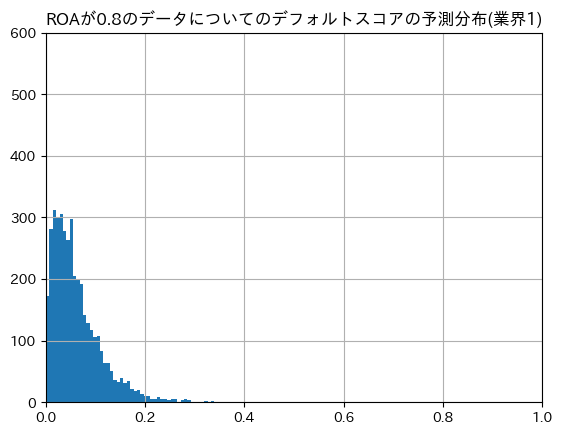

Default
0    2
Name: count, dtype: int64


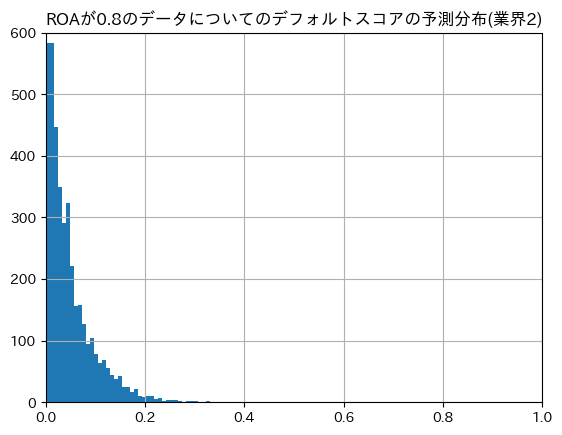

Default
0    2
Name: count, dtype: int64


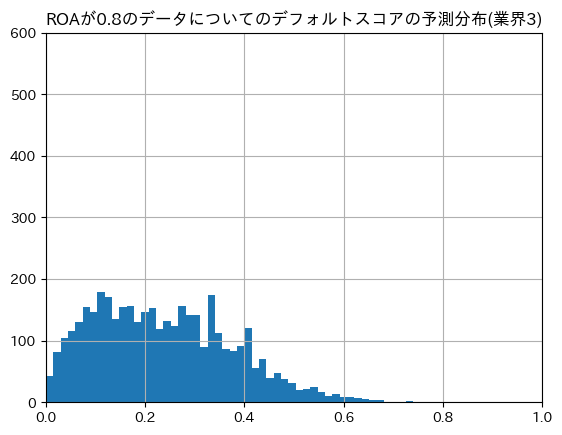

Default
1    2
0    1
Name: count, dtype: int64


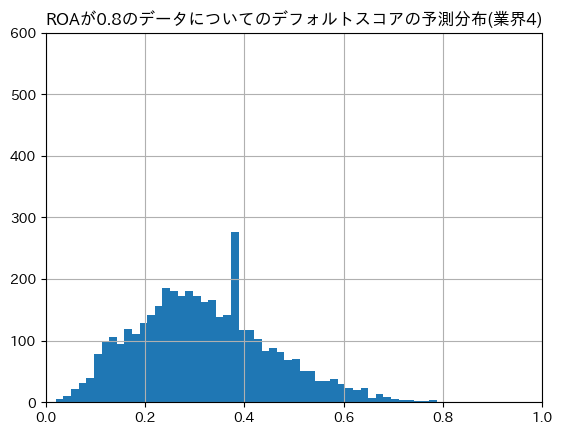

Default
1    1
Name: count, dtype: int64


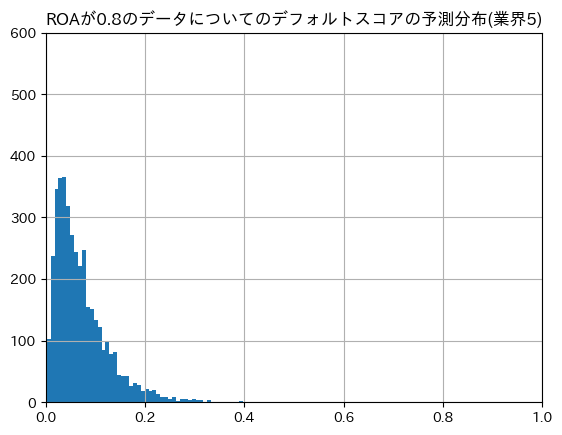

Series([], Name: count, dtype: int64)


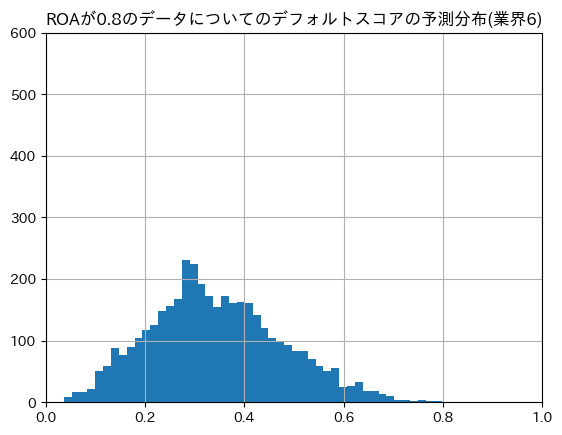

In [19]:
# ROAが1のデフォルトスコアの分布
roa = 0.8
for i in range(len(pd.Series(cl_array).unique())):
  # パラメータ抽出
  br_array = idata1.posterior["br"].values[:, :, i].reshape(4000, 1)
  b0_array = idata1.posterior["b0"].values[:, :, i].reshape(4000, 1)

  # 貸倒確率予測
  pred_prob_array = 1 / (1 + np.exp(-(br_array * roa + b0_array)))

  # 描画
  pd.DataFrame(pred_prob_array).hist(bins=50)
  plt.title(f"ROAが{roa}のデータについてのデフォルトスコアの予測分布(業界{i+1})")
  plt.xlim(0, 1)
  plt.ylim(0, 600)

  train_df_i = train_df[train_df["BusinessSectorLabel"] == i + 1]
  train_df_i_roa = train_df_i[(train_df_i["ReturnOnAsset"] >= roa - 0.1) & (train_df_i["ReturnOnAsset"] <= roa + 0.1)]
  print(train_df_i_roa["Default"].value_counts())


  plt.show()

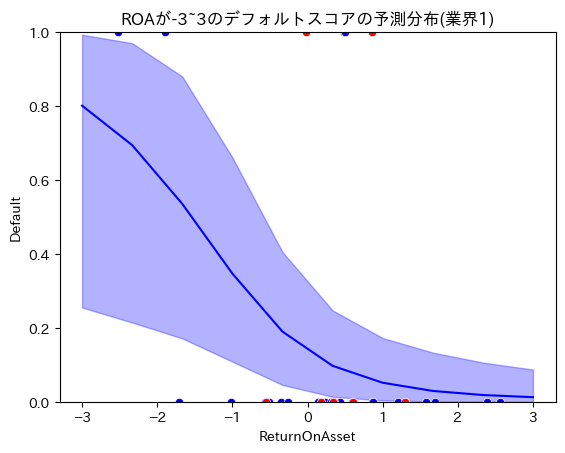

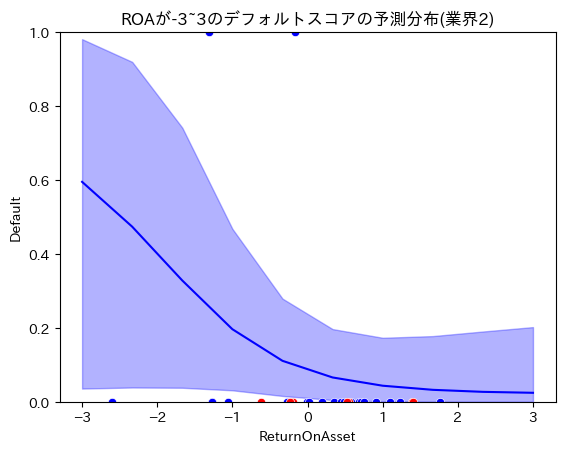

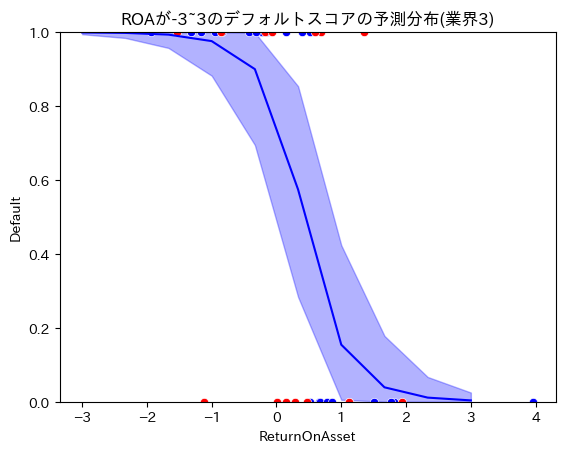

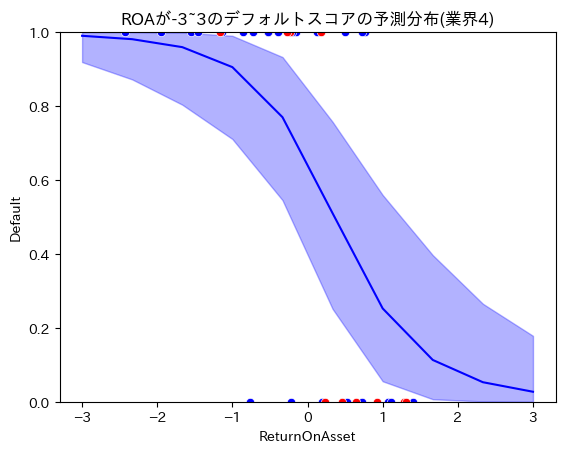

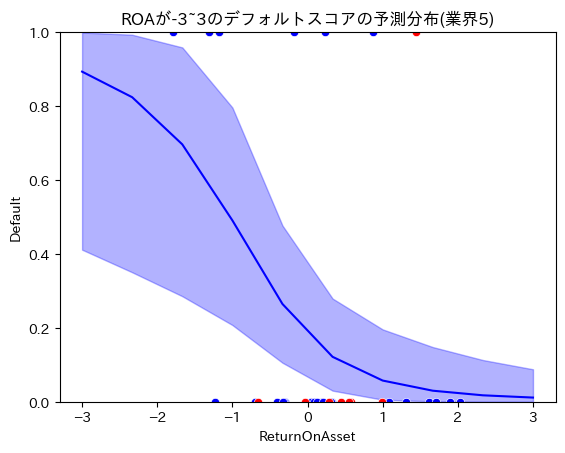

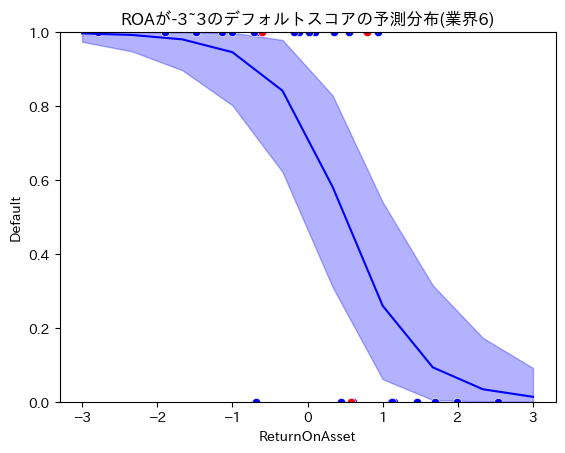

In [20]:
# ROAが-3~3の範囲でのデフォルトスコアの分布
plot_num = 10
t_data =  np.linspace(-3, 3, plot_num)
draw_range = 95

for i in range(len(pd.Series(cl_array).unique())):
  # パラメータ抽出
  br_array = idata1.posterior["br"].values[:, :, i].reshape(4000, 1)
  b0_array = idata1.posterior["b0"].values[:, :, i].reshape(4000, 1)

  # 予測
  pred_prob_array = 1 / (1 + np.exp(-(br_array @ t_data.reshape(1, plot_num) + b0_array)))

  # 描画
  fig, ax = plt.subplots()
  sns.lineplot(x=t_data, y=pred_prob_array.mean(axis=0), color="b")
  plt.fill_between(
      t_data,
      np.percentile(pred_prob_array, 100 - (100 - draw_range) / 2, axis=0),
      np.percentile(pred_prob_array, (100 - draw_range) / 2, axis=0),
      color="b",
      alpha=0.3,
  )

  ax = sns.scatterplot(
      x=train_df[train_df["BusinessSectorLabel"] == i + 1]["ReturnOnAsset"],
      y=train_df[train_df["BusinessSectorLabel"] == i + 1]["Default"],
      color="b"
  )
  ax = sns.scatterplot(
      x=valid_df[valid_df["BusinessSectorLabel"] == i + 1]["ReturnOnAsset"],
      y=valid_df[valid_df["BusinessSectorLabel"] == i + 1]["Default"],
      color="r"
  )

  ax.set(ylim=(0, 1))
  ax.set_title(f"ROAが-3~3のデフォルトスコアの予測分布(業界{i+1})")

## 売掛金の回収金額の予測分布

In [21]:
# 売掛金の回収金額の予測分布(経営者目線)
# 確率予測
threshold = 65 # 予測確率の上位65%点を予測に利用
accounts_collectible_data = np.zeros(4000)
for i in range(len(pd.Series(cl_array).unique())):
  br_array = idata1.posterior["br"].values[:, :, i].reshape(4000, 1)
  b0_array = idata1.posterior["b0"].values[:, :, i].reshape(4000, 1)

  # 予測するデータを抽出
  test_df_selected = test_df[test_df["BusinessSectorLabel"] == i+1]
  test_LoanValue = test_df_selected["LoanValue"].values.reshape(1, len(test_df_selected))
  test_roa = test_df_selected["ReturnOnAsset"].values.reshape(1, len(test_df_selected))

  # 貸倒予測
  pred_prob_array = 1 / (1 + np.exp(-(br_array @ test_roa + b0_array)))
  y_pred = np.random.binomial(1, pred_prob_array)

  # 予測回収金額を計算
  accounts_collectible = (1 - y_pred) * test_LoanValue
  accounts_collectible_sum = accounts_collectible.sum(axis=1)
  accounts_collectible_data = accounts_collectible_data + accounts_collectible_sum

print(accounts_collectible_data.shape)
print(accounts_collectible_data)

(4000,)
[1691732.00276561 2371805.09301516 1993711.95432323 ... 2367507.10383062
 2048079.46278957 1976314.9252672 ]


Text(0.5, 0, '回収金額')

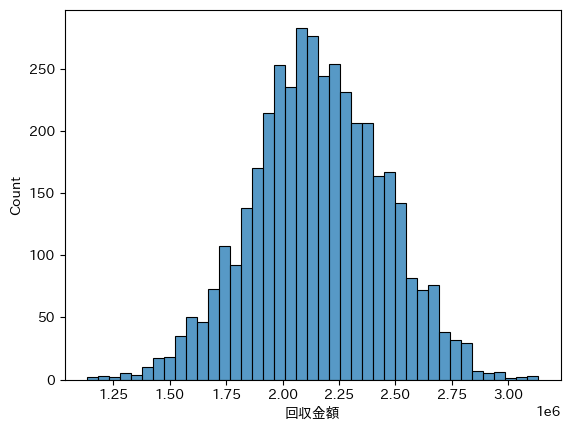

In [22]:
# 回収金額の分布を描画
ax = sns.histplot(
    data = accounts_collectible_data
)
ax.set_xlabel("回収金額")

In [23]:
# 平均値、中央値、95%HDI(回収金額の幅)
account_data = pd.Series(accounts_collectible_data)
mean = round(account_data.mean() / 1000)
median = round(account_data.median() / 1000)
ci = np.quantile(account_data, [0.025, 0.975]) / 1000
print(f"平均値：{mean}円")
print(f"中央値：{median}円")
print(f"95%HDI：{round(ci[0])}円〜{round(ci[1])}円")

平均値：2157円
中央値：2148円
95%HDI：1580円〜2720円
